# Bayesian Inversion of Complexometric Data
### Equilibrium Reactions: 

$$M_f + L_1  \leftrightarrow ML_1$$
$$M_f + L_2 \leftrightarrow ML_2 $$ 



### Geoverning Equations: 

$$K_1 = \frac{[ML_1]}{[M_f][L_1']} $$
$$K_2 = \frac{[ML_2]}{[M_f][L_2']} $$

$$ [L_{1}]_T = [L_1'] + [ML_1] $$
$$ [L_{2}]_T = [L_2'] + [ML_2] $$

$$ \alpha_{inorg}  = \frac{[M_{inorg}]  + [M_f]}{[M_f]}  = \frac{[M']}{[M_f]} $$
$$ [M_T] = \Sigma [ML_i] + [M'] $$


In [ ]:
import numpy as np 
from scipy.optimize import root, root_scalar, fsolve, brentq
from scipy.integrate import simps
from scipy.linalg import block_diag, det, eig
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import dual_annealing 
from functools import partial


In [ ]:
def SpecForwardModel_2L(MT, LT, K):
  # this fnction calclates M_free using a scalar root finding 
  # LT is an array of [L1T, L2T]
  # K is an array of [K1, K2]
  LT = LT / 1e9 # converting nano Molar to Molar
  MT = MT / 1e9 # converting nano Molar to Molar
  ligType = LT.size
  
  def objf(X): 
    # scalar function to be solved for the roots (M_free) 
    ML1 = (K[0]*LT[0]*X/1e9) / (1+K[0]*X/1e9)
    ML2 = (K[1]*LT[1]*X/1e9) / (1+K[1]*X/1e9)
    return (MT - ML1 - ML2 - X/1e9) 
  
  initGuess = 10**(np.linspace(-12,3,100))
  sol = []
  for i in range(initGuess.size - 1):
    try:
      sol.append(brentq(objf, initGuess[i], initGuess[i+1], maxiter=100))
    except ValueError:
      sol.append(np.nan)
  
  
  return np.nanmin(np.array(sol))

def TitrSimulate_2L(MT, LT, K): 
  
  return np.array([SpecForwardModel_2L(mt, LT, K) for mt in MT])
 

In [ ]:
LT = np.array([2, 10])
K = np.array([1e14, 1e12])
MT_ = np.linspace(0.1,6,12); 
y_ = TitrSimulate_2L(MT_,LT, K)
y_obs = y_ + y_*0.03*np.random.normal(0,1,MT_.size)

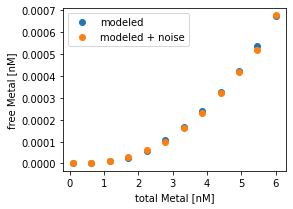

In [ ]:
plt.figure(figsize=[4 , 3])

plt.scatter(MT_, y_)
plt.scatter(MT_,y_obs)
plt.legend(['modeled','modeled + noise'])
plt.xlabel('total Metal [nM]')
plt.ylabel('free Metal [nM]')


plt.show()

In [ ]:
def lik( y_obs, Mt, X, relative_err = 0.03):
  # using analytical definition of normal distribution
  LT = X[:2]
  K = X[2:]
  y_ = TitrSimulate_2L(Mt, LT, K)

  mu = y_ - y_obs  

  cov_inv = np.diag( 1 / (y_obs * relative_err)**2) #  relative_error = 0.1 means raw y_obs can be between its 80 to 125 %
  
  resExp = np.matmul(mu.reshape(1,-1), np.matmul(cov_inv, mu.reshape(-1,1)))
  
  # tmp = 10**20 # scale to avoid underflow 
  return  ((2*np.pi)**(- y_obs.size /2)) * (det(cov_inv) ** -0.5) * np.exp(-0.5 * resExp.item())

def target(lik , y_obs, prior, Mt, X): 
  LT = X[:2]
  K = X[2:]
  return lik( y_obs, Mt, X) * prior[0].pdf(LT[0]) * prior[1].pdf(LT[1]) * prior[2].pdf(np.log10(K[0])) * prior[3].pdf(np.log10(K[1]))
"""
def lik_ratio(y_obs, prior, Mt, X_p, X_0, relative_err = 0.03):
 
  y_p = np.log10(TitrSimulate(Mt, X_p[0], X_p[1])[:,1])
  y_0 = np.log10(TitrSimulate(Mt, X_0[0], X_0[1])[:,1])
  y_obs = np.log10(y_obs)
  
  mu_p = y_p - y_obs
  mu_0 = y_0 - y_obs

  cov_inv = np.diag(np.ones_like(Mt) /(relative_err**2)) #  relative_error = 0.1 means raw y_obs can be between its 80 to 125 %
  
  resExp_p = np.matmul(mu_p.reshape(1,-1), np.matmul(cov_inv, mu_p.reshape(-1,1)))
  
  resExp_0 = np.matmul(mu_0.reshape(1,-1), np.matmul(cov_inv, mu_0.reshape(-1,1)))
  
  prr = prior[0].pdf(X_p[0]) * prior[1].pdf(np.log10(X_p[1])) / prior[0].pdf(X_0[0]) / prior[1].pdf(np.log10(X_0[1]))

  return np.array([np.exp(-0.5 * (resExp_p.item() - resExp_0.item())) * prr]) 
"""



'\ndef lik_ratio(y_obs, prior, Mt, X_p, X_0, relative_err = 0.03):\n \n  y_p = np.log10(TitrSimulate(Mt, X_p[0], X_p[1])[:,1])\n  y_0 = np.log10(TitrSimulate(Mt, X_0[0], X_0[1])[:,1])\n  y_obs = np.log10(y_obs)\n  \n  mu_p = y_p - y_obs\n  mu_0 = y_0 - y_obs\n\n  cov_inv = np.diag(np.ones_like(Mt) /(relative_err**2)) #  relative_error = 0.1 means raw y_obs can be between its 80 to 125 %\n  \n  resExp_p = np.matmul(mu_p.reshape(1,-1), np.matmul(cov_inv, mu_p.reshape(-1,1)))\n  \n  resExp_0 = np.matmul(mu_0.reshape(1,-1), np.matmul(cov_inv, mu_0.reshape(-1,1)))\n  \n  prr = prior[0].pdf(X_p[0]) * prior[1].pdf(np.log10(X_p[1])) / prior[0].pdf(X_0[0]) / prior[1].pdf(np.log10(X_0[1]))\n\n  return np.array([np.exp(-0.5 * (resExp_p.item() - resExp_0.item())) * prr]) \n'

### Grid Search 

In [ ]:
lb = [1,   9, 10**13.5, 10**11.5] # LT1 LT2 K1 K2
ub = [3, 11, 10**14.5, 10**12.5]
LB = [lb[0], lb[1], np.log10(lb[2]), np.log10(lb[3])]
Range = [ub[0] - lb[0], ub[1] - lb[1] , np.log10(ub[2]) - np.log10(lb[2]), np.log10(ub[3]) - np.log10(lb[3])]

prior = [st.uniform(LB[0], Range[0]) , st.uniform(LB[1],Range[1]), st.uniform(LB[2],Range[2]), \
         st.uniform(LB[3], Range[3])]

n_grids = 20

LT1_1Dgrid, LT1_stp = np.linspace(lb[0],ub[0], n_grids, retstep= True)
LT2_1Dgrid, LT2_stp = np.linspace(lb[1],ub[1], n_grids, retstep= True)

K1_1Dgrid, K1_stp = np.linspace(np.log10(lb[2]) , np.log10(ub[2]), n_grids, retstep=True)
K2_1Dgrid, K2_stp = np.linspace(np.log10(lb[3]) , np.log10(ub[3]), n_grids, retstep=True)

LT1_grid, LT2_grid, K1_grid, K2_grid  = np.meshgrid(LT1_1Dgrid , LT2_1Dgrid, K1_1Dgrid, K2_1Dgrid)

X_grid = np.concatenate((LT1_grid.flat[:], LT2_grid.flat[:], 10**(K1_grid.flat[:]), 10**(K2_grid.flat[:]))).reshape(-1, LT1_grid.size)

probs = np.zeros_like(LT1_grid)

for i in range(LT1_grid.size):
  
  probs.flat[i] = 10**20*target(lik , y_obs, prior, MT_, X_grid[:,i])
  if i%1000==0:
    print(i)


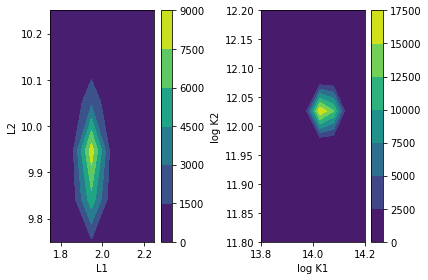

In [ ]:
probs[np.isnan(probs)] = 0
probs_n = probs / probs.sum() / (LT1_stp * K1_stp *LT2_stp * K2_stp)

plt.subplot(1,2,1)

plt.contourf(LT1_1Dgrid, LT2_1Dgrid, probs_n.sum(axis = (2,3)))
plt.xlabel('L1')
plt.ylabel('L2')
plt.xlim([1.75, 2.25])
plt.ylim([9.75, 10.25])
#plt.clim([0, 9])
plt.colorbar()

plt.subplot(1,2,2)

plt.contourf(K1_1Dgrid, K2_1Dgrid, probs_n.sum(axis = (0,1)))
plt.xlabel('log K1')
plt.ylabel('log K2')
plt.xlim([13.8, 14.2])
plt.ylim([11.8, 12.2])
#plt.clim([0, 9])
plt.colorbar()

plt.tight_layout()
plt.show()

### Performing an Optimization to Maximize a Priori

In [ ]:
lb = [1,   5, 10**11, 10**11] # LT1 LT2 K1 K2
ub = [10, 12, 10**15, 10**15]
LB = [lb[0], lb[1], np.log10(lb[2]), np.log10(lb[3])]
LB = np.array(LB)

Range = [ub[0] - lb[0], ub[1] - lb[1] , np.log10(ub[2]) - np.log10(lb[2]), np.log10(ub[3]) - np.log10(lb[3])]
Range = np.array(Range)
UB = LB + Range 

prior = [st.uniform(LB[0], Range[0]) , st.uniform(LB[1],Range[1]), st.uniform(LB[2],Range[2]), \
         st.uniform(LB[3], Range[3])]

def optfun(x, lik, MT, y_obs):
  tmp = np.log10(target(lik, y_obs, prior, MT, x))
  if ~np.isfinite(tmp):
    tmp = - 1000
  return -1 * tmp

LB[2:] = 10**LB[2:]
UB[2:] = 10**UB[2:]

optfun_ = partial(optfun, lik = lik, MT = MT_, y_obs = y_obs)


In [ ]:
ret = dual_annealing(func = optfun_, bounds = list(zip(LB,UB)), maxiter = 10000, seed=2442)

In [ ]:
print(ret.x)

[5.29971046e+00 5.97388124e+00 2.93859527e+14 9.87618776e+14]


### Improved Metropolis-Hastings with Automatic Selection of Step Size

In [ ]:
lb = [1,   1, 10**11, 10**11] # LT1 LT2 K1 K2
ub = [100, 100, 10**15, 10**15]
LB = [lb[0], lb[1], np.log10(lb[2]), np.log10(lb[3])]
LB = np.array(LB)

Range = [ub[0] - lb[0], ub[1] - lb[1] , np.log10(ub[2]) - np.log10(lb[2]), np.log10(ub[3]) - np.log10(lb[3])]
Range = np.array(Range)
UB = LB + Range 

prior = [st.uniform(LB[0], Range[0]) , st.uniform(LB[1],Range[1]), st.uniform(LB[2],Range[2]), \
         st.uniform(LB[3], Range[3])]


naccept = 0

x_0 = ret.x # initial guess 


niters = 100000
samples = np.zeros((niters+1,x_0.size))
samples[0,:] = x_0

step = np.array([0.1 , 0.1, 0.02, 0.02]) # maximum step size for LT and log10(K), respectively  # initial

NM = x_0.size # number of parameters 
PPR_target = (1/2)**(1/NM)

PPR = [1, 1, 1, 1]

RR_opt = 0.766 #optimal rejection rate


for i in range(niters):
    
    # check for step-size
    if (i > 0) & (i < 20000):
      if (i < 1000 and (i % 100) == 0) or (i >= 1000 and (i % 1000) == 0):
        tmp = target(lik, y_obs, prior, x_0)
        for i in range(NM):
          x_0_ = x_0
          if i < NM/2:
            x_0_[i] = x_0_[i] + 0.5 * step[i]
            PPR[i] = tmp / target(lik, y_obs, prior, x_0_)
          else:
            x_0_[i] = 10**(np.log10(x_0_[i]) + 0.5 * step[i])
            PPR[i] = tmp / target(lik, y_obs, prior, x_0_)
        
        for kk in range(len(PPR)):
          if PPR[kk] > 1:
            PPR[kk] = 1/PPR[kk]
        
        RR_ = (i - naccept) / i # current rejection rate
        PPR_target = PPR_target * (RR_ / RR_opt)
        if PPR_target < 1e-6:
          PPR_target = 1e-6
        PPR_diff = np.array(PPR_target) - np.array(PPR)
        
        j=-1
        for ppr_d in PPR_diff:
          j += 1
          if ppr_d > 0:
            step[j] = step[j] * np.exp((- ppr_d) /  PPR_target * 2)
          else:
            step[j] = step[j] * np.exp((- ppr_d) / (1 - PPR_target)*2)   
          #print(step)
          print(RR_)
    if i==20000:
      print('no more step updating!')
    #updating parameters

    x_p[:NM//2] = x_0[:NM//2] + step[:NM//2] * st.uniform(-1,2).rvs(NM//2)
    x_p[NM//2:] = 10**(np.log10(x_0[NM//2:]) + step[NM//2:] * st.uniform(-1,2).rvs(NM//2))

    #checking if parameters are within the range of prior uniform distribution
    
    tmp1 = x_p[:NM//2]
    tmp2 = np.log10(x_p[NM//2:])
    tmp1[tmp1<LB[:NM//2]] = 2*LB[tmp1<LB[:NM//2]] - tmp1[tmp1<LB[:NM//2]]
    tmp1[tmp1>UB[:NM//2]] = 2*UB[tmp1>UB[:NM//2]] - tmp1[tmp1>UB[:NM//2]]
    
    tmp2[tmp2<np.log10(LB[NM//2:])] = 2*LB[tmp2<np.log10(LB[:NM//2+1])] - tmp2[tmp2<np.log10(LB[:NM//2+1])]
    tmp2[tmp2>np.log10(UB[NM//2:])] = 2*UB[tmp2>np.log10(UB[:NM//2+1])] - tmp2[tmp2>np.log10(UB[:NM//2+1])]
 
  
    rho = min(1, target(lik, y_obs, prior, MT_, x_p)/target(lik, y_obs, prior, MT_, x_0))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        x_0 = x_p
    del a 
    samples[0,i+1] = x_0

print('done!')

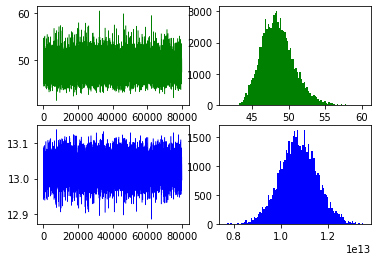

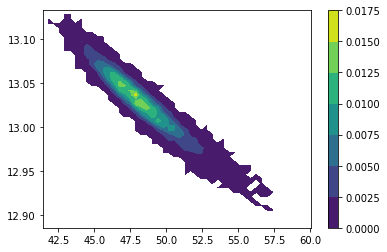

In [ ]:
plt.subplot(2,2,1)
plt.plot(samples[20000:,0], 'g' , linewidth = 0.5)

plt.subplot(2,2,2)
plt.hist(samples[20000:,0],100, color='g')

plt.subplot(2,2,3)
plt.plot(np.log10(samples[20000:,1]),'b' , linewidth = 0.5) 

plt.subplot(2,2,4)
plt.hist(samples[niters//2:,1],100 , color='b')

plt.show()

H, x_edge, y_edge = np.histogram2d(samples[20000:,0],np.log10(samples[20000:,1]),bins = 50, density=True)

H = H / H.sum()
H[H==0] = np.nan
plt.contourf(x_edge[:-1], y_edge[:-1], H.T, cmap="viridis")


plt.colorbar()
plt.show()